<img src="https://www.anped.org.br/sites/default/files/images/ufcg-lateral.png" width="780" height="240" align="center"/>

## Centro de Engenharia Elétrica e Informática
## Departamento de Engenharia Elétrica
## Disciplina: Int. ao Processamento de Imagem Digital e Visão Computacional
## Professora: Luciana Veloso
## Aluno(a): Fabio Victor Galdino Nascimento

# Experimento 07.2: Classificação de Dígitos com Redes Convolucionais

In [1]:
import os                                             # Operational System para manipulação de arquivos.
import cv2                                            # OpenCV para manipulação de imagens.
import random
import numpy as np                                    # Numpy para manipulação de matrizes e arrays.
import matplotlib.pyplot as plt                       # Pyplot para plotagem de gráficos e imagens.
from sklearn.model_selection import train_test_split  # Função para particionamento dos dados

from tensorflow.keras.models import Sequential        # Classe de modelos sequenciais para construir as redes neurais.
from tensorflow.keras.utils import to_categorical     # Função para preprocessamento dos gabaritos.
from tensorflow.keras.datasets import mnist           # Dataset utilizado nesse experimento.

from tensorflow.keras import layers                   # Módulo de camadas do Keras
from tensorflow.keras import callbacks                # Módulo de callbacks do Keras
from tensorflow.keras import optimizers               # Módulo de otimizadores do Keras

## 1. Banco de Dados

* Vamos utilizar o MNIST, outro banco de dados presente no catálogo de datasets do Keras, que é disponibilizado como uma função pronta;

* Cada instância do banco de dados corresponde a uma imagem rotulada de um dígito manuscrito;

* As imagens do banco de dados são monocromáticas e de dimensões 28 x 28;

* Os gabaritos correspondem ao número manuscrito, sendo um inteiro entre 0 e 9;

* O banco de dados contém 60.000 imagens para treino e 10.000 imagens para teste;

### 1.1 Organização do banco de dados

* Como vimos, a primeira dimensão dos arrays do banco de dados é reservada para controlar a amostra e as demais correspondem às demais dimensões do tipo de dados utilizado. 

* Nesse caso, os nossos dados são imagens monocromáticas (2D), de modo que são organizados em tensores tridimensionais (3D) com formato: **dados.shape = (amostras, altura, largura)**
    * O i-ésimo exemplo pode ser acessado a partir de: **exemplo = dados[i]**
    * Um pedaço de uma imagem pode ser acessado de forma similar:
        * Quadrante superior esquerdo da i-ésima imagem: **quad = dados[i, :14, :14]**
        

* O banco de dados pode ser carregado utilizando:
    * **(train_data, train_targets), (test_data, test_targets) = mnist.load_data()**
    * train_data é um tensor com as entradas do conjunto de treino;
    * test_data é um tensor com as entradas do conjunto de teste;
    * train_targets é um tensor com os gabaritos do conjunto de treino;
    * test_targets é um tensor com os gabaritos do conjunto de teste;

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

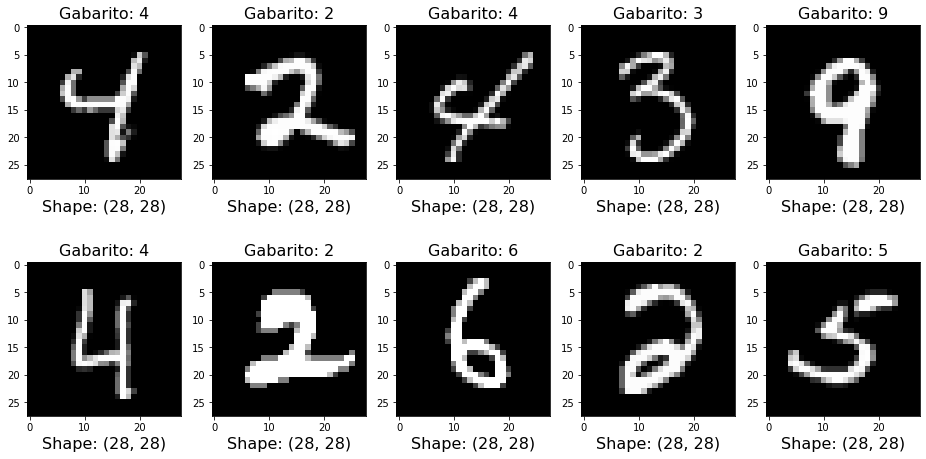

In [3]:
# Escolhe exemplos aleatórios
indices = np.random.randint(0, 60000-1, 10)

# Plots
fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize=(16, 8))

for i, idx in enumerate(indices):
    
    # Plota a imagem
    axs[i//5][i%5].imshow( train_images[idx], vmin=0, vmax=255, cmap="gray" )
    
    # Adiciona o gabarito como título
    axs[i//5][i%5].set_title( "Gabarito: {}".format(train_labels[idx]), fontsize = 16 )
    
    # Adiciona o shape como subtítulo
    axs[i//5][i%5].set_xlabel( "Shape: {}".format(train_images[idx].shape), fontsize = 16 )

### 1.2 Pre-processamento dos dados de entrada

* Como estamos utilizando Redes Neurais Convolucionais 2D, precisamos que a entrada seja seja um array tetradimensional (4D), sendo necessário adicionar uma dimensão para os canais.

* Para isso, podemos utilizar a função **reshape(shape)** que reorganiza um array para um determinado formato especificado desde que seja possível alocar todos os valores do array original para o novo formato.

* Além disso, como em uma imagem todos os pixels são valores entre 0 e 255, podemos pre-processar os dados de entrada a partir de uma simples divisão por 255, que garante que todos os dados estarão entre 0 e 1.

In [9]:
def preprocess_data(data):
    # Desfaz adiciona uma dimensão para os canais da imagem
    data = data.reshape((len(data), 28, 28, 1))
    # Normaliza os valores ao dividir pelo maior valor possível dentro das imagens.
    data = data.astype("float32")/255
    return data

preprocessed_train_images = preprocess_data(train_images)
preprocessed_test_images  = preprocess_data(test_images)

**a. Verifique as dimensões e a faixa de valores dos dados de treino e teste após o pré-processamento. Não é necessário verificar a faixa de valores para cada característica isoladamente.**

In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
test_images.shape

(10000, 28, 28)

In [10]:
#Conjunto Treino

amostras, altura, largura = train_images.shape

for i in range(largura):
    print('{} | Limites: (min: {:.2f} , max: {:.2f}) | Média: {:.2f} | Variância: {:.2f}'.format(i,np.min(train_images[i]), 
    np.max(train_images[i]), np.mean(train_images[i]), np.var(train_images[i])))

0 | Limites: (min: 0.00 , max: 255.00) | Média: 35.11 | Variância: 6343.94
1 | Limites: (min: 0.00 , max: 255.00) | Média: 39.66 | Variância: 7037.06
2 | Limites: (min: 0.00 , max: 255.00) | Média: 24.80 | Variância: 4300.70
3 | Limites: (min: 0.00 , max: 255.00) | Média: 21.86 | Variância: 4366.42
4 | Limites: (min: 0.00 , max: 255.00) | Média: 29.61 | Variância: 5531.09
5 | Limites: (min: 0.00 , max: 255.00) | Média: 37.76 | Variância: 6577.97
6 | Limites: (min: 0.00 , max: 255.00) | Média: 22.51 | Variância: 4602.49
7 | Limites: (min: 0.00 , max: 255.00) | Média: 45.75 | Variância: 8102.99
8 | Limites: (min: 0.00 , max: 255.00) | Média: 13.87 | Variância: 2768.36
9 | Limites: (min: 0.00 , max: 255.00) | Média: 27.94 | Variância: 5120.58
10 | Limites: (min: 0.00 , max: 254.00) | Média: 36.41 | Variância: 6827.62
11 | Limites: (min: 0.00 , max: 255.00) | Média: 18.18 | Variância: 3454.10
12 | Limites: (min: 0.00 , max: 255.00) | Média: 45.61 | Variância: 7955.17
13 | Limites: (min: 0.

In [11]:
#Conjunto Treino

for i in range(largura):
    print('Coluna: {} | Limites: (min: {:.2f} , max: {:.2f}) | Média: {:.2f} | Variância: {:.2f}'.format(i,np.min(test_images[i]), 
    np.max(test_images[i]), np.mean(test_images[i]), np.var(test_images[i])))

Coluna: 0 | Limites: (min: 0.00 , max: 255.00) | Média: 23.54 | Variância: 4353.41
Coluna: 1 | Limites: (min: 0.00 , max: 255.00) | Média: 36.80 | Variância: 6705.26
Coluna: 2 | Limites: (min: 0.00 , max: 255.00) | Média: 12.59 | Variância: 2387.94
Coluna: 3 | Limites: (min: 0.00 , max: 255.00) | Média: 47.21 | Variância: 8538.50
Coluna: 4 | Limites: (min: 0.00 , max: 255.00) | Média: 24.54 | Variância: 4476.75
Coluna: 5 | Limites: (min: 0.00 , max: 254.00) | Média: 17.67 | Variância: 3542.10
Coluna: 6 | Limites: (min: 0.00 , max: 255.00) | Média: 27.02 | Variância: 4864.94
Coluna: 7 | Limites: (min: 0.00 , max: 255.00) | Média: 26.86 | Variância: 5055.72
Coluna: 8 | Limites: (min: 0.00 , max: 255.00) | Média: 39.20 | Variância: 7137.80
Coluna: 9 | Limites: (min: 0.00 , max: 255.00) | Média: 39.99 | Variância: 7202.68
Coluna: 10 | Limites: (min: 0.00 , max: 255.00) | Média: 37.96 | Variância: 6664.36
Coluna: 11 | Limites: (min: 0.00 , max: 255.00) | Média: 35.38 | Variância: 5990.44
Co

### 1.3 Particionamento dos dados de treino

* Agora vamos criar uma partição de validação a partir do conjunto de treino para realizar uma validação cruzada. 

* Novamente vamos utilizar a função **train_test_split**, que separa dados e os seus respectivos gabaritos segundo uma fração especificada.

* Contudo, dessa vez utilizaremos o parâmetro **stratify**, que indica os rótulos associados aos dados fornecidos. Quando esse parâmetro é fornecido a função realiza o particionamento dos dados e mantém a proporção entre exemplos de uma mesma classe com relação aos dados originais.

In [12]:
# Fração escolhida para separar o mesmo número de instâncias do conjunto de testes
data_frac = preprocessed_test_images.shape[0] / preprocessed_train_images.shape[0]

# Criação do conjunto de validação
preprocessed_train_images, preprocessed_val_images, train_labels, val_labels = train_test_split(preprocessed_train_images, # Dados de treino
                                                                                                train_labels,              # Gabaritos de treino
                                                                                                test_size = data_frac,     # Proporção de dados p/ validação
                                                                                                stratify = train_labels,   # Dados de referência
                                                                                                random_state=42)           # Semente para garantir consistencia nos resultados

print("Treino:", preprocessed_train_images.shape, train_labels.shape)
print("Validação:", preprocessed_val_images.shape, val_labels.shape)

Treino: (50000, 28, 28, 1) (50000,)
Validação: (10000, 28, 28, 1) (10000,)


### 1.4 Pre-processamento dos gabaritos

* Nesse caso temos um problema multiclasse com 10 classes, sendo elas correspondentes aos números entre 0 e 9. Consequentemente, o modelo produzido terá 10 unidades de saída, uma para cada classe, e utilizará a função de ativação softmax.

* Para fornecer esses gabaritos para a rede durante o treinamento é necessário categorizar as saídas, para limitá-las ao intervalo [0, 1]. Para isso vamos utilizar a função to_categorical() disponível no próprio Keras.

In [25]:
categorical_train_labels = to_categorical(train_labels)
categorical_val_labels   = to_categorical(val_labels)
categorical_test_labels  = to_categorical(test_labels)

### 1.5 Construindo o modelo

Para construir o modelo usaremos a classe **Sequential**, que possibilita a construção de modelos sequenciais de forma bastante simples.
* A construção do modelo é feita a partir do seu instanciamento como objeto da classe seguido de chamadas à função **add()** para adicionar camadas.
* Como estamos construindo Redes Neurais Convolucionais, vamos utilizar as camadas **Input**, **Conv2D**, **MaxPooling2D**, **Dropout**, **Flatten** e **Dense**.
    * A camada Input cria a entrada da rede com **Input( shape )**
        * shape corresponde ao formato do tensor de entrada, no nosso caso será o número de características do nosso banco de dados (28, 28, 1);
    * A camada Conv2D pode ser chamada com **Conv2D( num_kernels, kernel_size, activation = 'linear' )**
        * num_kernels corresponde ao número de conjuntos de filtros aplicados, determina o número de mapas de características na saída;
        * kernel_size é uma tupla (altura, largura) que determina o tamanho dos filtros;
        * activation corresponde à função de ativação utilizada na camada;
    * A camada MaxPooling2D pode ser chamada com **MaxPooling2D( kernel_size )**
        * kernel_size é uma tupla (altura, largura) que determina o tamanho dos filtros;
    * A camada Dropout pode ser chamada com **Dropout( drop_chance )**
        * drop_chance é um float que determina a chance de dropout na camada;
    * A camada Flatten pode ser chamada com **Flatten( )**
        * Essa camada "achata" os volumes de dados dos tensores de imagens e transforma em um vetor coluna;
    * A camada Dense pode ser chamada com **Dense( n_unidades, activation = 'linear' )**
        * n_unidades corresponde ao número de neurônios da camada;
        * activation corresponde à função de ativação utilizada na camada;
        
        
* Algumas funções de ativação disponíveis são:
    * "linear"
    * "relu"
    * "sigmoid"
    * "softmax"
    * "tanh"


* Mais informações sobre a camada dense podem ser vistas em **https://keras.io/api/layers/core_layers/dense/**
* Mais informações sobre as ativações disponíveis podem ser vistas em **https://keras.io/api/layers/activations/**

**b. A função abaixo constroi um modelo de rede neural e utiliza a função summary() para apresentar um resumo das informações da rede neural produzida. Comente o que faz cada linha do código.**

* Modifique parâmetros como o número de filtros de cada camada e/ou o formato do tensor de entrada e/ou o número de saídas. 
* Explique como o número de parâmetros de cada camada é calculado. Esse valor depende do tamanho das imagens de entrada?

In [26]:
def build_model( input_shape, n_outputs ):
    rede = Sequential() #Construção do modelo sequencial
    rede.add( layers.Input( ( input_shape ) ) ) #Adiciona a camada de entrada da rede
    
    rede.add( layers.Conv2D(32, (3, 3), activation='relu') ) #Adiciona a camada Conv2D, informando o número de conjuntos de filtros aplicados, altura, largura e a função de ativação
    rede.add( layers.MaxPooling2D( (2, 2) ) ) #Adiciona a camada MaxPooling2D, em seguida espesificando a altura e largura
    rede.add( layers.Dropout( 0.30 ) ) #Adiciona a camada Dropou e determinamos a chance de dropout na camada.

    rede.add( layers.Conv2D(64, (3, 3), activation='relu') ) #Realiza o mesmo processo das anteriores, porém muda alguns parametros 
    rede.add( layers.MaxPooling2D( (2, 2) ) )
    rede.add( layers.Dropout( 0.25 ) )
    
    rede.add( layers.Flatten() ) #Adiciona a camada Flatten que "achata" os volumes de dados dos tensores de imagens e transforma em um vetor coluna
    rede.add( layers.Dense(  128, activation = "relu") ) #Adiciona a acamada Dense, informamos número de neurônios da camada e a função de ativação
    rede.add( layers.Dense( n_outputs, activation = "softmax" ) )#Mesmo processo do anterior, dessa vez o número de neurônios será a igual ao número de saída
    
    return rede

model = build_model( (28, 28, 1), 10 ) #Chamando a função e passando os parametros 
model.summary() #Mostra o sumário da rede

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1600)            

In [27]:
model = build_model( (28, 28, 1), 10 )
model.compile(optimizer=optimizers.Adam(lr=1e-3), 
              loss="categorical_crossentropy", 
              metrics=["acc"])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1600)            

<font color = 'red'>
 
**Comentário:** 
    
Os parâmetros também podemos chamar de pesos e eles são aprendíveis, então eles podem se atualizar e escolher qual será o melhor valor para um bom desempenho do modelo. “Param #” mostra o número de parâmetros que são treinados para cada camada e o número total de parâmetros é mostrado no final, que é igual ao número de parâmetros treináveis e não treináveis. 
    
E sim, depende do tamanho da imagem de entrada.
    
</font>

### Callbacks

* Dessa vez utilizaremos uma das callbacks do Keras, o Model_Checkpoint.
* Essa função salva o modelo conforme o treinamento é executado à medida que os valores da variável monitorada melhoram, preservando sempre o modelo com os melhores valores obtidos.
* model_checkpoint = ModelCheckpoint( path, monitor = None, save_best_only = True, verbose = 1)
    * path é o caminho para o salvamento do modelo;
    * monitor é a variável que deve ser monitorada pelo callback;
    * save_best_only indica se só o melhor modelo deve ser salvo ou se todos os aumentos devem ser salvos;
    * verbose é o modo de texto, 1 indica para que o Keras avise quando um novo modelo for salvo;

In [28]:
model_checkpoint = callbacks.ModelCheckpoint("model.hdf5", monitor = "val_acc", save_best_only = True, verbose = 1)

### 1.6 Treinando o modelo

O treinamento é realizado a partir da função **fit**, que recebe dados de treino e de validação além de hiperparâmetros como o número de épocas e o tamanho dos lotes de dados (batchsize).

* **hist = model.fit( x = None, y = None, epochs = 1, batchsize = None, callbacks = [], validation_data = None, verbose = "auto")**
    * x corresponde aos dados de treino;
    * y corresponde aos gabaritos de treino;
    * epochs corresponde ao número de épocas de treinamento;
    * batchsize corresponde ao tamanho dos lotes entregues à rede de cada vez;
    * callbacks corresponde à lista de callbacks utilizada;
    * validation_data corresponde a uma tupla ( val_data, val_targets ) com os dados de validação;
    * verbose indica como a função deve reportar os resultados:
        * 0: modo silencioso, nenhum retorno em formato de texto;
        * 1: retorno a cada época e barra de progresso;
        * 2: retorno a cada época sem barra de progresso;
    * hist é um dicionário de retorno com os valores de loss e das métricas computadas para treino e validação;
    
    
    
* Lista de callbacks disponíveis: https://keras.io/api/callbacks/

In [29]:
history = model.fit( preprocessed_train_images, categorical_train_labels, 
                     epochs=10, batch_size=128, callbacks = [model_checkpoint], 
                     validation_data = (preprocessed_val_images, categorical_val_labels) )
history_dict = history.history

Epoch 1/10
391/391 [==============================] - 44s 104ms/step - loss: 0.2984 - acc: 0.9096 - val_loss: 0.1015 - val_acc: 0.9698

Epoch 00001: val_acc improved from -inf to 0.96980, saving model to model.hdf5
Epoch 2/10
391/391 [==============================] - 42s 108ms/step - loss: 0.0870 - acc: 0.9728 - val_loss: 0.0609 - val_acc: 0.9823

Epoch 00002: val_acc improved from 0.96980 to 0.98230, saving model to model.hdf5
Epoch 3/10
391/391 [==============================] - 41s 105ms/step - loss: 0.0642 - acc: 0.9796 - val_loss: 0.0473 - val_acc: 0.9868

Epoch 00003: val_acc improved from 0.98230 to 0.98680, saving model to model.hdf5
Epoch 4/10
391/391 [==============================] - 40s 103ms/step - loss: 0.0501 - acc: 0.9837 - val_loss: 0.0428 - val_acc: 0.9863

Epoch 00004: val_acc did not improve from 0.98680
Epoch 5/10
391/391 [==============================] - 44s 113ms/step - loss: 0.0422 - acc: 0.9867 - val_loss: 0.0401 - val_acc: 0.9871

Epoch 00005: val_acc improv

### Plots

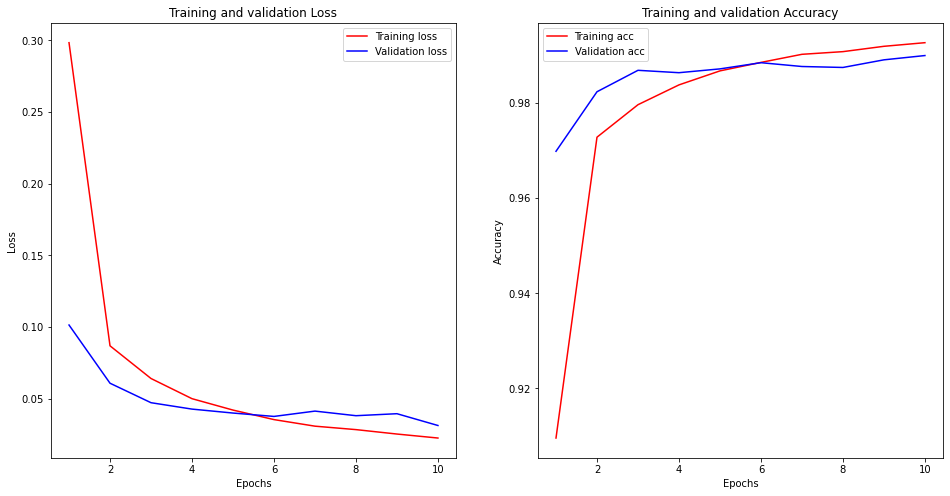

In [30]:
fig, axes = plt.subplots(1, 2, squeeze = False, figsize = (16,8))

# Loss
train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Epochs
epochs = range(1, len(train_loss_values) + 1)

# Accuracy
train_acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

ax = axes.flat[0]
ax.plot(epochs, train_loss_values, 'r', label='Training loss')
ax.plot(epochs, val_loss_values, 'b', label='Validation loss')
ax.set_title('Training and validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

ax = axes.flat[1]
ax.plot(epochs, train_acc_values, 'r', label='Training acc')
ax.plot(epochs, val_acc_values, 'b', label='Validation acc')
ax.set_title('Training and validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()

### 1.7 Teste

O teste do modelo pode ser realizado a partir da função **evaluate**, que recebe os dados de treino e retorna o valor de loss calculado para esse conjunto e os valores de cada métrica da lista fornecida durante a compilação do modelo. 

* É uma prática comum realizar ajustes no modelo com base no conjunto de validação e só utilizar o conjunto de testes após a definição dos hiperparâmetros definitivos.
* Como os hiperparâmetros são ajustados a partir dos resultados obtidos para o conjunto de validação, o modelo pode acabar. sobreajustando aos dados de validação, então é interessante mudar os dados desse conjunto com frequência.
* Para mudar os dados de validação basta alterar a semente na função train_test_split.
* Crie um novo modelo do zero após a realização de mudanças nos conjuntos de treino/validação.

**c. As Redes Convolucionais obtiveram melhores resultados que as Redes Neurais Artificiais nesse banco de dados? Alguma das Redes Neurais Artificiais produzidas na parte 1 obtiveram resultados comparáveis?**

* Modifique parâmetros como o número de unidades de cada camada e/ou o formato do tensor de entrada e/ou o número de saídas. 
* Explique como o número de parâmetros de cada camada é calculado.

<font color = 'red'>
 
**Comentário:** 
    
O resultado com redes convolucionais foram melhores. De princípio os resultados são semelhantes, mas logo percebemos que já na época 2, a acurácia da rede convolucional é bem superior e os gráficos seguem em melhor sintonia.
   
Os parâmetros são calculados de acordo com qual peso o computador consegue identificar melhor a imagem e acertar o gabarito.

    
</font>

In [31]:
test_loss, test_acc = model.evaluate(preprocessed_test_images, categorical_test_labels)

print("Test Accuracy:", 100*test_acc, "%")
print("Acertos: {} - Erros: {}".format(round(len(preprocessed_test_images)*test_acc), 
                                       round(len(preprocessed_test_images)*(1-test_acc) )))

313/313 [==============================] - 3s 8ms/step - loss: 0.0260 - acc: 0.9917
Test Accuracy: 99.16999936103821 %
Acertos: 9917 - Erros: 83


# Visualização dos Resultados

In [32]:
def show_results(xtest, ytest, ypred, num = 25, tipo = "rand"):
    
    if tipo == "acertos":
        fltr_idx = [i for i in range(xtest.shape[0]) if ypred[i] == ytest[i]]
    else:
        fltr_idx = [i for i in range(xtest.shape[0]) if ypred[i] != ytest[i]]
        
    indices = np.random.choice(fltr_idx, min(num, len(fltr_idx)), replace=False)
       
    rows = int(num/5)
    fig, axs = plt.subplots(nrows = rows, ncols = 5, figsize=(20, 4*rows))
    
    for i, idx in enumerate(indices):
        img = xtest[idx]
        if ypred[idx] == ytest[idx]:
            axs[i//5][i%5].set_title(str(ytest[idx]), color = "green", fontsize = 20)
        else:
            axs[i//5][i%5].set_title("Pred: {} - Gabarito: {}".format(ypred[idx], ytest[idx]), color = "red", fontsize = 20)
        
        axs[i//5][i%5].imshow(img, vmin=0, vmax=255, cmap = "gray")
    return

pred_labels = model.predict(preprocessed_test_images, verbose=1)
preds = np.argmax(pred_labels, axis = -1)

313/313 [==============================] - 3s 9ms/step


### Acertos

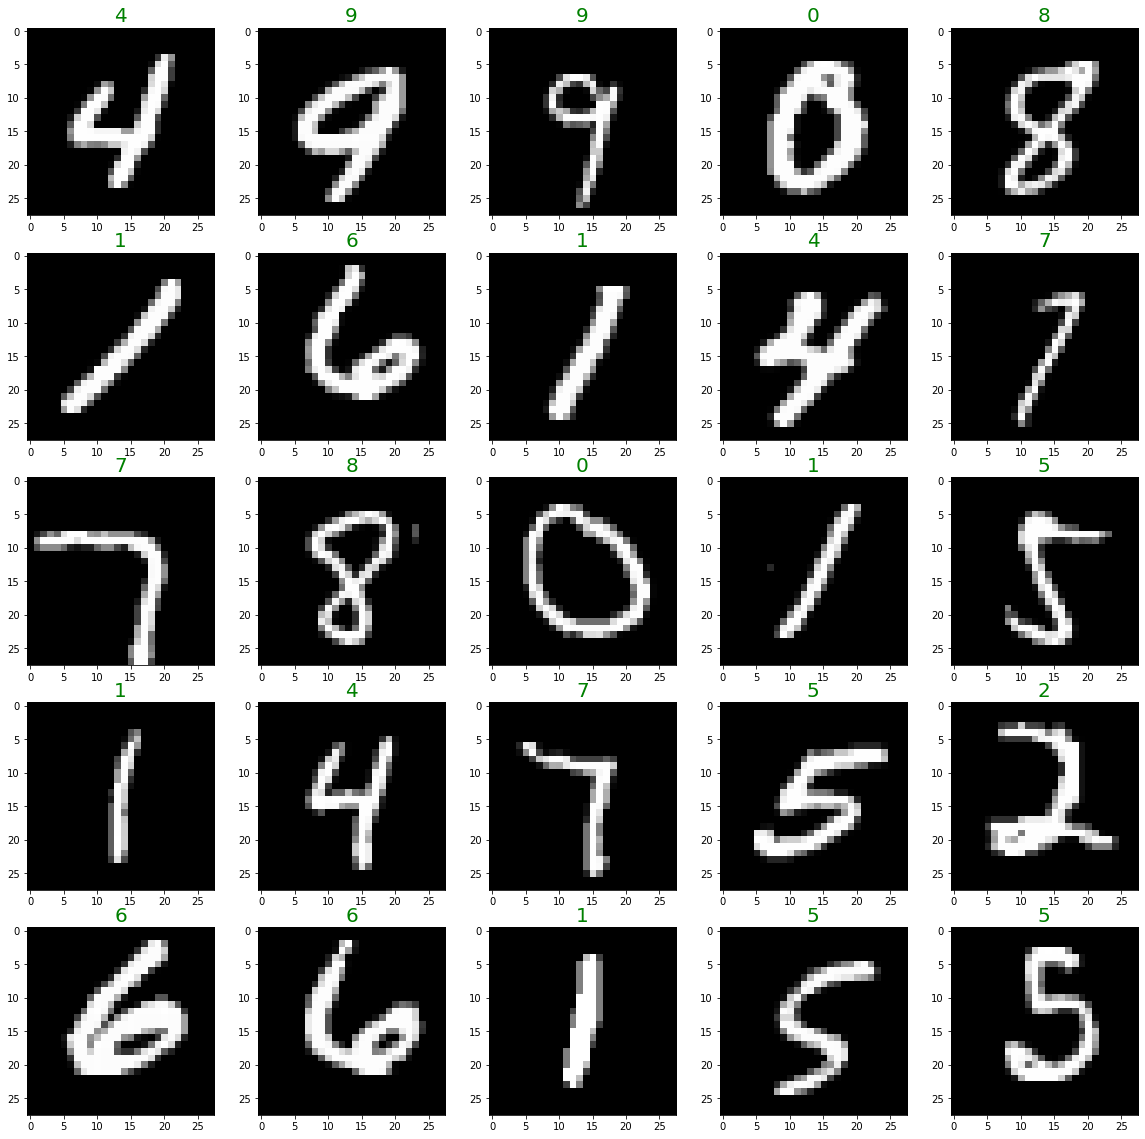

In [33]:
show_results(test_images, test_labels, preds, tipo = "acertos")

### Erros

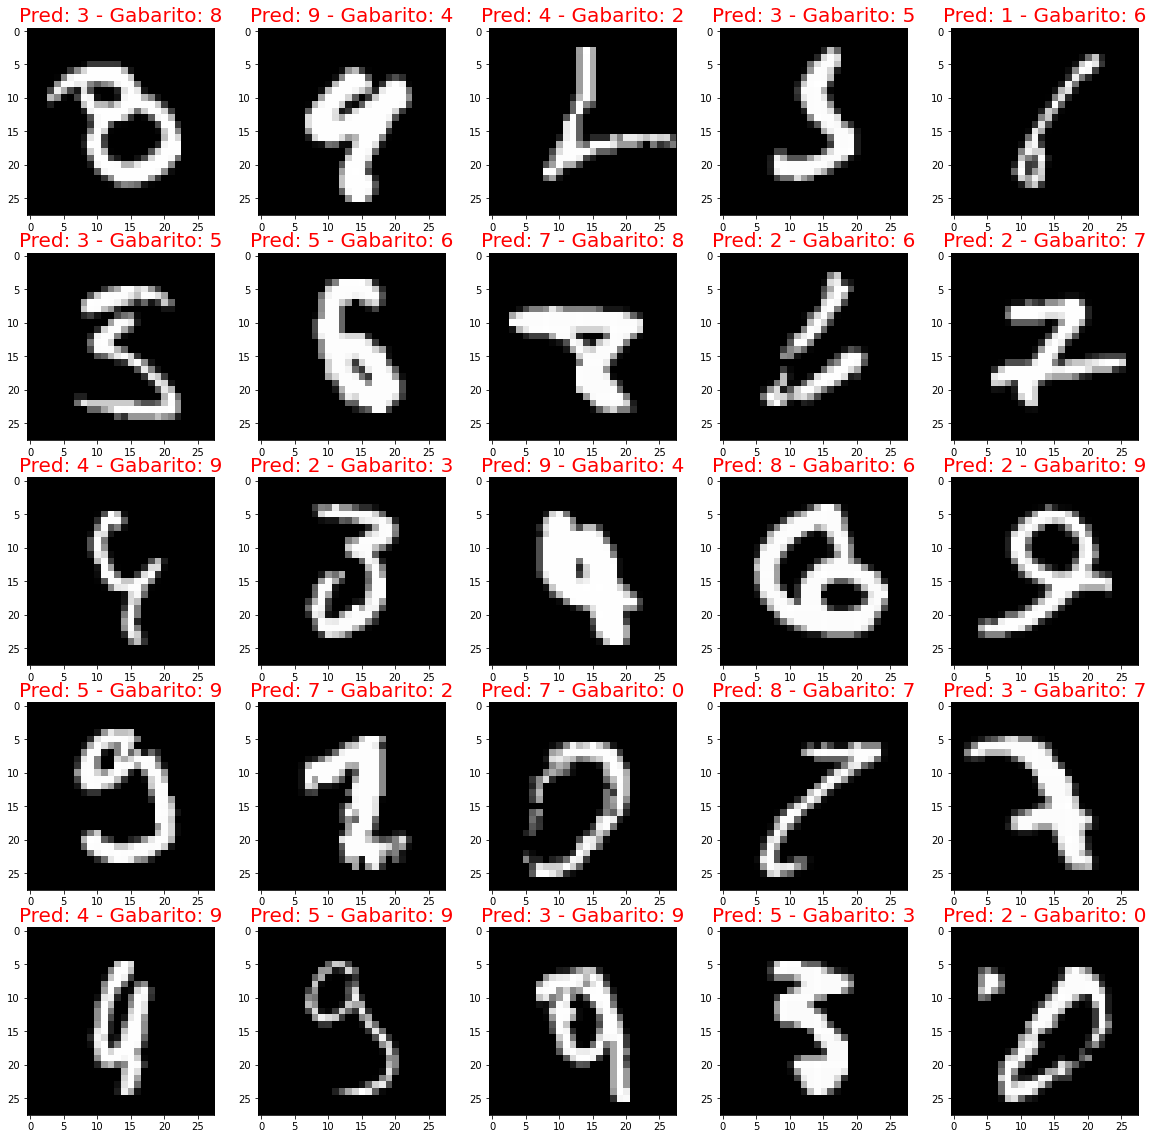

In [34]:
show_results(test_images, test_labels, preds, tipo = "erros")